<a href="https://colab.research.google.com/github/RafaelLizardoo/Trabalho-de-I.A-Una/blob/main/Projeto_A3_I_A_5_Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import text_to_word_sequence
import re, os

from keras.models import Model

from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
seed = 7
np.random.seed(seed)

# O model será exportado para este arquivo
filename='/content/model/model_saved.h5'

epochs = 5

# dimensionalidade do word embedding pré-treinado
word_embedding_dim = 50

# número de amostras a serem utilizadas em cada atualização do gradiente
batch_size = 32

# Reflete a quantidade máxima de palavras que iremos manter no vocabulário
max_fatures = 5000

# dimensão de saída da camada Embedding
embed_dim = 128

# limitamos o tamanho máximo de todas as sentenças
max_sequence_length = 300

pre_trained_wv = False

bilstm = False

In [5]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')


    return string.strip().lower()

In [6]:
def prepare_data(data):
    
    data = data[['text','sentiment']]

    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data['text'].apply(lambda x: clean_str(x))
    data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    
    stop_words = set(stopwords.words('portuguese'))
    text = []
    for row in data['text'].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [w for w in word_list if not w in stop_words]
        no_stop_words = " ".join(no_stop_words)
        text.append(no_stop_words)


    tokenizer = Tokenizer(num_words=max_fatures, split=' ')

    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)  
    
    X = pad_sequences(X, maxlen=max_sequence_length)
    #X = pad_sequences(X)

    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['sentiment']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer

In [7]:
    data = pd.read_excel('/content/dataset/imdb.xlsx')

X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1600, 300) (1600, 2)
(400, 300) (400, 2)


In [8]:
def load_pre_trained_wv(word_index, num_words, word_embedding_dim):
    embeddings_index = {}
    f = open(os.path.join('./word_embedding', 'glove.6B.{0}d.txt'.format(word_embedding_dim)), encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('%s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((num_words, word_embedding_dim))
    for word, i in word_index.items():
        if i >= max_fatures:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [17]:
def model():
    
    if pre_trained_wv is True:
        print("USE PRE TRAINED")
        num_words = min(max_fatures, len(word_index) + 1)
        weights_embedding_matrix = load_pre_trained_wv(word_index, num_words, word_embedding_dim)
        input_shape = (max_sequence_length,)
        model_input = Input(shape=input_shape, name="input", dtype='int32')    
        embedding = Embedding(
            num_words, 
            word_embedding_dim,
            input_length=max_sequence_length, 
            name="embedding", 
            weights=[weights_embedding_matrix], 
            trainable=False)(model_input)
        if bilstm is True:
            lstm = Bidirectional(LSTM(word_embedding_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm"))(embedding)
        else:
            lstm = LSTM(word_embedding_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)

    else:
        input_shape = (max_sequence_length,)
        model_input = Input(shape=input_shape, name="input", dtype='int32')    

        embedding = Embedding(max_fatures, embed_dim, input_length=max_sequence_length, name="embedding")(model_input)
        
        if bilstm is True:
            lstm = Bidirectional(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm"))(embedding)
        else:
            lstm = LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    
    model_output = Dense(2, activation='softmax', name="softmax")(lstm)
    model = Model(inputs=model_input, outputs=model_output)
    return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 softmax (Dense)             (None, 2)                 258       
                                                                 
Total params: 771,842
Trainable params: 771,842
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
50/50 [==============================] - 46s 869ms/step - loss: 0.6770 - accuracy: 0.5838 - val_loss: 0.6441 - val_accuracy: 0.7550
Epoch 2/10
50/50 [===================

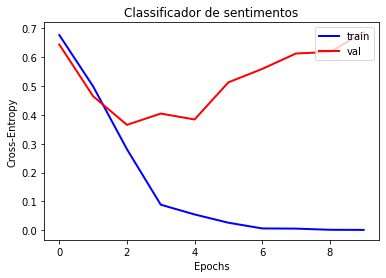

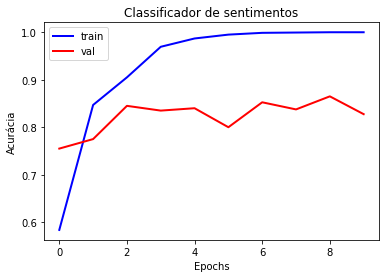

Acc: 82.75%


In [18]:
model = model()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

if not os.path.exists('./{}'.format(filename) ):

    hist = model.fit(
        X_train, 
        Y_train, 
        validation_data=(X_test, Y_test),
        epochs=epochs,
        batch_size=batch_size, 
        shuffle=True,
        verbose=1)

    model.save_weights(filename)    


    # Plot
    plt.figure()
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('Classificador de sentimentos')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend(loc='upper right')
    plt.show()

    plt.figure()
    plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title('Classificador de sentimentos')
    plt.xlabel('Epochs')
    plt.ylabel('Acurácia')
    plt.legend(loc='upper left')
    plt.show()

else:
    model.load_weights('./{}'.format(filename) )

scores = model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("Acc: %.2f%%" % (scores[1]*100))

In [19]:
while True:
    sentence = input("input> ")

    if sentence == "exit":
        break
    
    new_text = [sentence]
    new_text = tokenizer.texts_to_sequences(new_text)

    new_text = pad_sequences(new_text, maxlen=max_sequence_length, dtype='int32', value=0)

    sentiment = model.predict(new_text,batch_size=1,verbose = 2)[0]

    if(np.argmax(sentiment) == 0):
        pred_proba = "%.2f%%" % (sentiment[0]*100)
        print("negativo => ", pred_proba)
    elif (np.argmax(sentiment) == 1):
        pred_proba = "%.2f%%" % (sentiment[1]*100)
        print("positivo => ", pred_proba)

input> O último filme de velozes e furiosos foi horrível, história muito ruim e com contexto tediante.
1/1 - 0s - 308ms/epoch - 308ms/step
negativo =>  99.70%
input> Amei o filme do capitão américa, produção muito boa, e história legal!
1/1 - 0s - 60ms/epoch - 60ms/step
positivo =>  93.40%
input> exit
